# TBC
- output a csv per metric:
    - euc
    - dtw
    - soft-dtw
- one row for each algorithm, k, cluster
- each row has center and metric scrore to center
    - Include min, max, avg, quantile scores?

# Clustering Centers and Scores
### $Time$ $Series$ $4th$ $Test$

$Vasco$ $Mergulhão$ $-$ $April$ $2023$

### Version 1:
This script calcules the clusters centers and respective scores according to different simillarity measures:
- Euclidean
- DTW
- kMedoids-DTW

In [282]:
from dtaidistance.dtw_barycenter import dba_loop as dba_centre
from sktime.clustering.k_medoids import TimeSeriesKMedoids
from tslearn.barycenters import euclidean_barycenter as euc_center

from dtaidistance.ed import distance as euc_dist
from dtaidistance.dtw import distance_fast as dtw_dist
from sktime.clustering.k_medoids import TimeSeriesKMedoids

In [343]:
import pandas as pd
import polars as pl
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import Transform

---
# Script Variabels

In [3]:
dataset_name = 'Kenya_90k_Set_1_w90_pW'
solution_name = 'LSTM_AE-efficient_sweep_2_v49'

In [4]:
dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'

sol_location = f'../ModelResults/Clustering/Solutions/{dataset_name}/{solution_name}.csv'

window_cols, window_len = Transform.retrive_window_col_names(dataset_name)

---
# Data Imports

In [5]:
df_data = pl.read_csv(dataset_location)

---
# Ploting Functions

In [248]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [271]:
def plot_elbow(df_centers, alg = 'kMeans', mode = 'Total_Score', line_type = 'avg'):
    
    df = df_centers[df_centers['Algorithm'] == alg]
    
    if line_type == 'avg': 
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['k', mode]].groupby('k').agg('mean').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        
    elif line_type == 'w_avg':
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['Cluster_Size', 'k', mode]].groupby('k').apply(w_avg, mode, 'Cluster_Size').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        df_line.rename(columns={0: mode}, inplace=True)    
    
    elif line_type == 'sum':
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['k', mode]].groupby('k').agg('sum').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        
    
    fig = go.Figure()

    fig.add_trace(
        go.Box(
            y=df[mode],
            x=df['k'],
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.5,
            fillcolor='rgba(93, 164, 214, 0.5)',
            marker_size=3,
            line_width=1.5,
        )
    )
        
    fig.add_trace(
        go.Scatter(
            x=df_line['k'],
            y=df_line[mode],
            mode = 'lines+markers',
            name = 'Average',
            marker_color='rgba(181, 60, 9, .6)'
        )
    )
        
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        template="seaborn",
        showlegend = False
    )
    
    fig.show()

In [328]:
def plot_centers(df_centers, alg = 'kMeans', k = 'k10'):
    
    df = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k)]
    sol_cols = pl.scan_csv(sol_location).columns[5:]

    max_c = int(sol_cols[-1].split('_')[-1][1:])

    fig = go.Figure()
    for c in range(1, max_c +1):
        fig.add_trace(
            go.Scatter(
                x=window_cols,
                y= df[df['cluster'] == c][window_cols].values.ravel(),
                mode='lines',
                name= f'Cluster: {c}'
            )
        )
        
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        template="seaborn",
        showlegend = True 
    )


    fig.show()
    

---
# Euclidean
https://dtaidistance.readthedocs.io/en/latest/usage/ed.html  
https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.euclidean_barycenter.html#tslearn.barycenters.euclidean_barycenter  

In [91]:
sol_cols = pl.scan_csv(sol_location).columns[5:]
# Calc total number of clusters
max_c = int(sol_cols[-1].split('_')[-1][1:])
algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# initiating lists
centroids = []
algorithms = []
k = []
clusters = []
avg_scores = []
total_scores = []
n_w_cluster = []
i = 0
for s, sol in enumerate(sol_cols):
    # Getting range of clusters for sol
    c_min = 1
    c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

    # Calculating Centroid/Barycenter per cluster per sol.
    for c in range(c_min, c_max + 1):
        i += 1
        print(f'Processing {sol} ({i}/{total_c})', end='\r')
        # print(f'\n{process}', end='\r')
        # Getting relevant windows (cluster points)
        df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
        df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
        sol_data = df_sol[window_cols].values
        
        n_w_cluster.append(len(sol_data))

        
        # Calculating cluster centre
        centroid = euc_center(sol_data).ravel()
        # Saving cluster centre
        centroids.append(centroid)
        
        # Saving Algorithm and k values
        algorithms.append(sol.split('_')[0])
        k.append(sol.split('_')[-1])
        clusters.append(c)
        
        # Calculating Average Score for respective metric
        scores = []
        for window in sol_data:
            score = euc_dist(centroid, window)
            scores.append(score)
        total_scores.append(np.sum(np.abs(scores)))
        avg_scores.append(np.mean(np.abs(scores)))
        
        
Euclidean_centres = pd.DataFrame(centroids, columns=window_cols)
Euclidean_centres.insert(0, "cluster", clusters)
Euclidean_centres.insert(0, "k", k)
Euclidean_centres.insert(0, "Algorithm", algorithms)
Euclidean_centres.insert(3, "Avg_Score", avg_scores)
Euclidean_centres.insert(3, "Total_Score", total_scores)
Euclidean_centres.insert(3, "Cluster_Size", n_w_cluster)

In [92]:
Euclidean_centres.head(9)

,Algorithm,k,cluster,Cluster_Size,Total_Score,Avg_Score,d1,d2,d3,d4,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans,k2,1,774739,5.859741e+06,7.563503,0.212162,0.206649,0.200486,0.189885,...,-0.017431,-0.018052,-0.017998,-0.019601,-0.019865,-0.020459,-0.019774,-0.018890,-0.017778,-0.017270
1,kMeans,k2,2,49923,1.154119e+05,2.311799,-6.828842,-6.919791,-6.999395,-6.999211,...,-6.892829,-6.879198,-6.854200,-6.830666,-6.816834,-6.799896,-6.781538,-6.764383,-6.744071,-6.724425
2,kMeans,k3,1,22934,4.677449e+05,20.395262,-5.490786,-5.542045,-5.605953,-5.714933,...,-6.657989,-6.627377,-6.560713,-6.516039,-6.471779,-6.411950,-6.339369,-6.267215,-6.218091,-6.146787
3,kMeans,k3,2,46376,1.930992e+04,0.416377,-6.857141,-6.934475,-6.999840,-6.999642,...,-7.000000,-6.999839,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.966233,-6.935094
4,kMeans,k3,3,755352,4.525317e+06,5.991004,0.353990,0.348628,0.342999,0.335435,...,0.158484,0.157809,0.157502,0.156057,0.155356,0.154050,0.153763,0.153612,0.152530,0.150273
5,kMeans,k4,1,382003,2.042588e+06,5.347047,0.766669,0.767035,0.761555,0.749492,...,0.476421,0.473720,0.471319,0.467820,0.464826,0.460840,0.458711,0.459352,0.460332,0.457301
6,kMeans,k4,2,22932,4.676574e+05,20.393224,-5.491043,-5.542307,-5.606220,-5.715209,...,-6.658348,-6.628130,-6.561459,-6.516782,-6.472518,-6.412683,-6.340096,-6.267936,-6.218808,-6.147497
7,kMeans,k4,3,373351,1.850332e+06,4.956012,-0.068269,-0.079491,-0.085273,-0.088233,...,-0.166835,-0.165414,-0.163578,-0.162921,-0.161275,-0.159839,-0.158242,-0.159203,-0.162395,-0.163860
8,kMeans,k4,4,46376,1.930992e+04,0.416377,-6.857141,-6.934475,-6.999840,-6.999642,...,-7.000000,-6.999839,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.966233,-6.935094


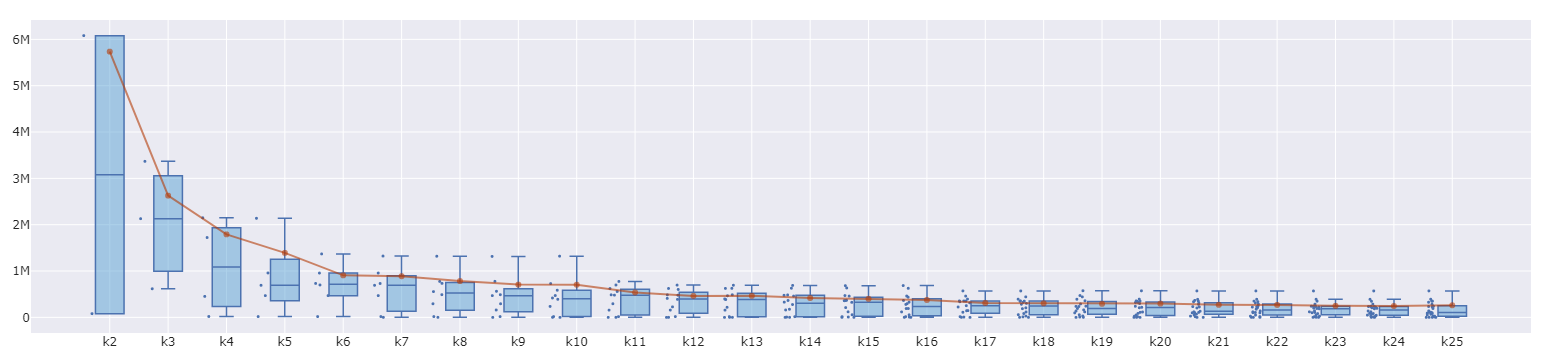

In [276]:
plot_elbow(Euclidean_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

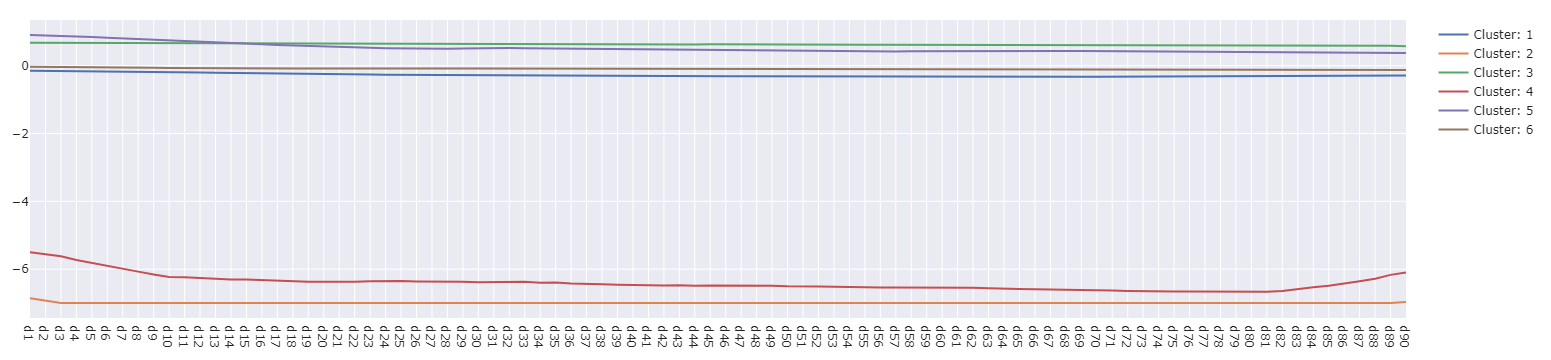

In [335]:
plot_centers(Euclidean_centres, alg='KUMAP', k = 'k6')

---
# DTW
https://dtaidistance.readthedocs.io/en/latest/modules/dtw_barycenter.html  
https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html#dtw-between-multiple-time-series

In [278]:
sol_cols = pl.scan_csv(sol_location).columns[5:]
# Calc total number of clusters
max_c = int(sol_cols[-1].split('_')[-1][1:])
algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# initiating lists
centroids = []
algorithms = []
k = []
clusters = []
avg_scores = []
total_scores = []
n_w_cluster = []
i = 0
for s, sol in enumerate(sol_cols):
    # Getting range of clusters for sol
    c_min = 1
    c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

    # Calculating Centroid/Barycenter per cluster per sol.
    for c in range(c_min, c_max + 1):
        i += 1
        print(f'Processing {sol} ({i}/{total_c})', end='\r')
        # print(f'\n{process}', end='\r')
        # Getting relevant windows (cluster points)
        df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
        df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
        sol_data = df_sol[window_cols].values
        
        n_w_cluster.append(len(sol_data))

        
        # Calculating cluster centre
        centroid = dba_centre(sol_data, max_it=10, thr=0.001, use_c=True)
        # Saving cluster centre
        centroids.append(centroid)
        
        # Saving Algorithm and k values
        algorithms.append(sol.split('_')[0])
        k.append(sol.split('_')[-1])
        clusters.append(c)
        
        # Calculating Average Score for respective metric
        scores = []
        for window in sol_data:
            score = dtw_dist(centroid, window)
            scores.append(score)
        total_scores.append(np.sum(np.abs(scores)))
        avg_scores.append(np.mean(np.abs(scores)))
        
        
DTW_centres = pd.DataFrame(centroids, columns=window_cols)
DTW_centres.insert(0, "cluster", clusters)
DTW_centres.insert(0, "k", k)
DTW_centres.insert(0, "Algorithm", algorithms)
DTW_centres.insert(3, "Avg_Score", avg_scores)
DTW_centres.insert(3, "Total_Score", total_scores)
DTW_centres.insert(3, "Cluster_Size", n_w_cluster)

In [279]:
DTW_centres.head(9)

,Algorithm,k,cluster,Cluster_Size,Total_Score,Avg_Score,d1,d2,d3,d4,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans,k2,1,1000,5812.078500,5.812079,0.791098,0.204386,-0.489278,0.406870,...,0.093218,0.195964,0.127036,-0.055528,0.878203,0.377265,0.217511,0.577378,0.220737,-0.604358
1,kMeans,k2,2,1000,2411.078364,2.411078,-6.834609,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-5.430371
2,kMeans,k3,1,1000,9381.959737,9.381960,-6.533812,-1.607551,-6.996338,-6.996338,...,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-3.826969
3,kMeans,k3,2,1000,354.429448,0.354429,-6.858257,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.910269
4,kMeans,k3,3,1000,3215.302064,3.215302,0.840233,0.248521,-0.456271,0.590002,...,0.485016,0.556766,0.498841,0.303893,0.981695,0.531767,0.692315,0.503137,0.219408,-0.426762
5,kMeans,k4,1,1000,3185.643122,3.185643,1.100417,0.674801,0.445474,0.200211,...,0.581423,0.956353,0.799194,0.783420,0.803369,0.767590,0.884947,0.754480,0.495052,0.103273
6,kMeans,k4,2,1000,9381.959737,9.381960,-6.533812,-1.607551,-6.996338,-6.996338,...,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-6.996338,-3.826969
7,kMeans,k4,3,1000,2235.987501,2.235988,0.219764,-0.115871,-0.166996,-0.731727,...,0.326230,0.325838,0.325069,0.324063,0.325675,0.304132,0.375449,0.302677,0.142736,-0.588066
8,kMeans,k4,4,1000,354.429448,0.354429,-6.858257,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.910269


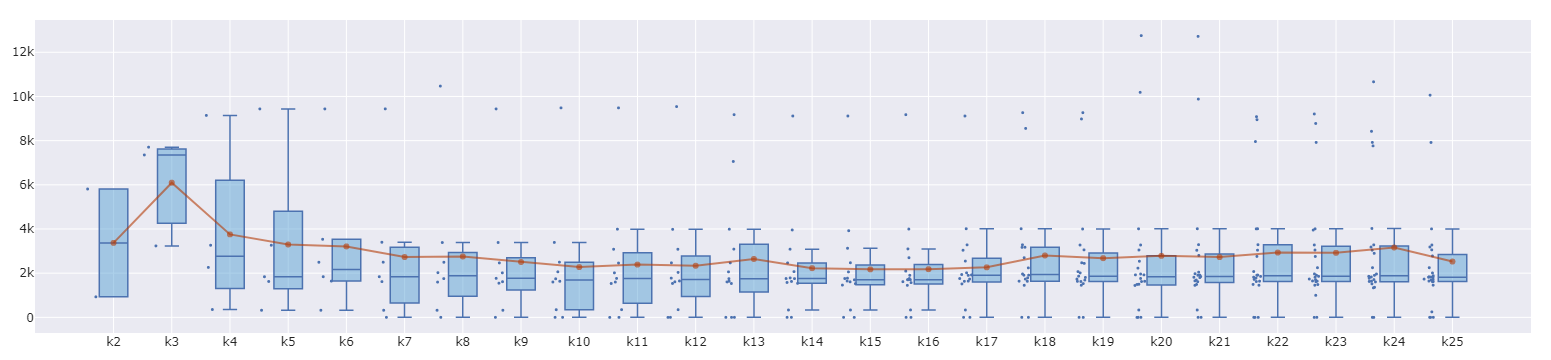

In [283]:
plot_elbow(DTW_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

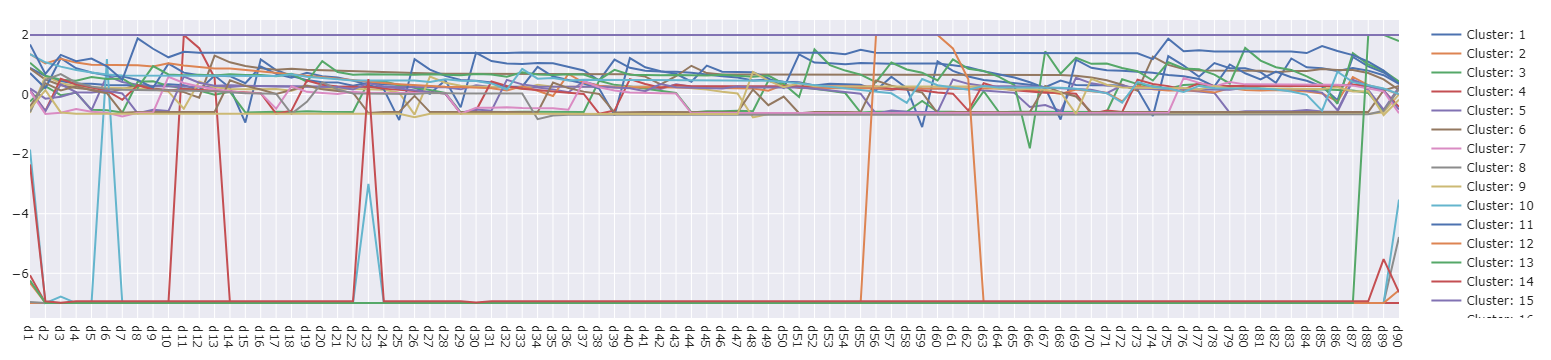

In [358]:
plot_centers(DTW_centres, alg='KUMAP', k = 'k25')

---
# kMedoids  - DTW
https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.clustering.k_medoids.TimeSeriesKMedoids.html#sktime.clustering.k_medoids.TimeSeriesKMedoids.fit_predict

In [336]:
# sol_cols = pl.scan_csv(sol_location).columns[5:]
# # Calc total number of clusters
# max_c = int(sol_cols[-1].split('_')[-1][1:])
# algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
# total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# # initiating lists
# centroids = []
# algorithms = []
# k = []
# clusters = []
# avg_scores = []
# total_scores = []
# n_w_cluster = []
# i = 0
# for s, sol in enumerate(sol_cols):
#     # Getting range of clusters for sol
#     c_min = 1
#     c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

#     # Calculating Centroid/Barycenter per cluster per sol.
#     for c in range(c_min, c_max + 1):
#         i += 1
#         print(f'Processing {sol} ({i}/{total_c})', end='\r')
#         # print(f'\n{process}', end='\r')
#         # Getting relevant windows (cluster points)
#         df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
#         df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
#         sol_data = df_sol[window_cols][:100].values
        
#         n_w_cluster.append(len(sol_data))

        
#         # Calculating cluster centre
#         kMedoids = TimeSeriesKMedoids(n_clusters = 1, metric = 'dtw', max_iter = 10, tol = 0.001)
#         kMedoids_model = kMedoids.fit(sol_data)
#         centroid = kMedoids_model.cluster_centers_.ravel()
#         # Saving cluster centre
#         centroids.append(centroid)
        
#         # Saving Algorithm and k values
#         algorithms.append(sol.split('_')[0])
#         k.append(sol.split('_')[-1])
#         clusters.append(c)
        
#         # Calculating Average Score for respective metric
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(centroid, window)
#             scores.append(score)
#         total_scores.append(np.sum(np.abs(scores)))
#         avg_scores.append(np.mean(np.abs(scores)))
        
        
# kMedoids_centres = pd.DataFrame(centroids, columns=window_cols)
# kMedoids_centres.insert(0, "cluster", clusters)
# kMedoids_centres.insert(0, "k", k)
# kMedoids_centres.insert(0, "Algorithm", algorithms)
# kMedoids_centres.insert(3, "Avg_Score", avg_scores)
# kMedoids_centres.insert(3, "Total_Score", total_scores)
# kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

In [337]:
# kMedoids_centres.head(9)

In [338]:
# plot_elbow(kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

In [339]:
# plot_centers(kMedoids_centres, alg='KUMAP', k = 'k10')

---
# DTAI "kMedoids"  - DTW


In [297]:
sol_cols = pl.scan_csv(sol_location).columns[5:]
# Calc total number of clusters
max_c = int(sol_cols[-1].split('_')[-1][1:])
algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# initiating lists
centroids = []
dtai_kmedoids = []
algorithms = []
k = []
clusters = []
avg_scores = []
total_scores = []
n_w_cluster = []
i = 0
for s, sol in enumerate(sol_cols):
    # Getting range of clusters for sol
    c_min = 1
    c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

    # Calculating Centroid/Barycenter per cluster per sol.
    for c in range(c_min, c_max + 1):
        i += 1
        print(f'Processing {sol} ({i}/{total_c})', end='\r')
        # print(f'\n{process}', end='\r')
        # Getting relevant windows (cluster points)
        df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
        df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
        sol_data = df_sol[window_cols].values
        
        n_w_cluster.append(len(sol_data))

        
        # Calculating cluster centre (DTW)
        centroid = dba_centre(sol_data, max_it=10, thr=0.001, use_c=True)
        # Saving cluster centre
        centroids.append(centroid)
       
        # Saving Algorithm and k values
        algorithms.append(sol.split('_')[0])
        k.append(sol.split('_')[-1])
        clusters.append(c)
        
        # Calculating cluster centre (kMedoid)
        scores = []
        for window in sol_data:
            score = dtw_dist(centroid, window)
            scores.append(score)
        idx_min = np.argmin(np.abs(scores))
        dtai_kmedoid = sol_data[idx_min]
        dtai_kmedoids.append(dtai_kmedoid)
        
        # Calculating Average Score for respective metric
        scores = []
        for window in sol_data:
            score = dtw_dist(dtai_kmedoid, window)
            scores.append(score)
        total_scores.append(np.sum(np.abs(scores)))
        avg_scores.append(np.mean(np.abs(scores)))
      
        
DTAI_kMedoids_centres = pd.DataFrame(dtai_kmedoids, columns=window_cols)
DTAI_kMedoids_centres.insert(0, "cluster", clusters)
DTAI_kMedoids_centres.insert(0, "k", k)
DTAI_kMedoids_centres.insert(0, "Algorithm", algorithms)
DTAI_kMedoids_centres.insert(3, "Avg_Score", avg_scores)
DTAI_kMedoids_centres.insert(3, "Total_Score", total_scores)
DTAI_kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

In [298]:
DTAI_kMedoids_centres.head(9)

,Algorithm,k,cluster,Cluster_Size,Total_Score,Avg_Score,d1,d2,d3,d4,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans,k2,1,100,480.276626,4.802766,0.238538,0.153046,0.067554,0.067554,...,0.148577,0.063085,0.063085,0.063085,0.063085,0.063085,0.063085,0.063085,0.063085,0.063085
1,kMeans,k2,2,100,11.519508,0.115195,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
2,kMeans,k3,1,100,1592.638941,15.926389,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
3,kMeans,k3,2,100,11.519508,0.115195,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
4,kMeans,k3,3,100,403.498065,4.034981,0.137466,0.052278,0.137466,0.052278,...,-0.596314,-0.596314,-0.596314,-0.596314,-0.596314,0.563946,0.478758,0.393570,0.308383,0.223195
5,kMeans,k4,1,100,427.165450,4.271655,0.883600,0.833600,0.783600,0.733600,...,0.783600,0.733600,0.683600,0.633600,0.583600,0.533600,0.483600,0.433600,0.383600,0.333600
6,kMeans,k4,2,100,1592.638941,15.926389,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
7,kMeans,k4,3,100,299.473368,2.994734,0.059973,0.059973,-0.643575,-0.643575,...,0.162073,0.070133,0.162073,0.070133,-0.643575,-0.643575,-0.643575,-0.643575,-0.643575,-0.643575
8,kMeans,k4,4,100,11.519508,0.115195,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000


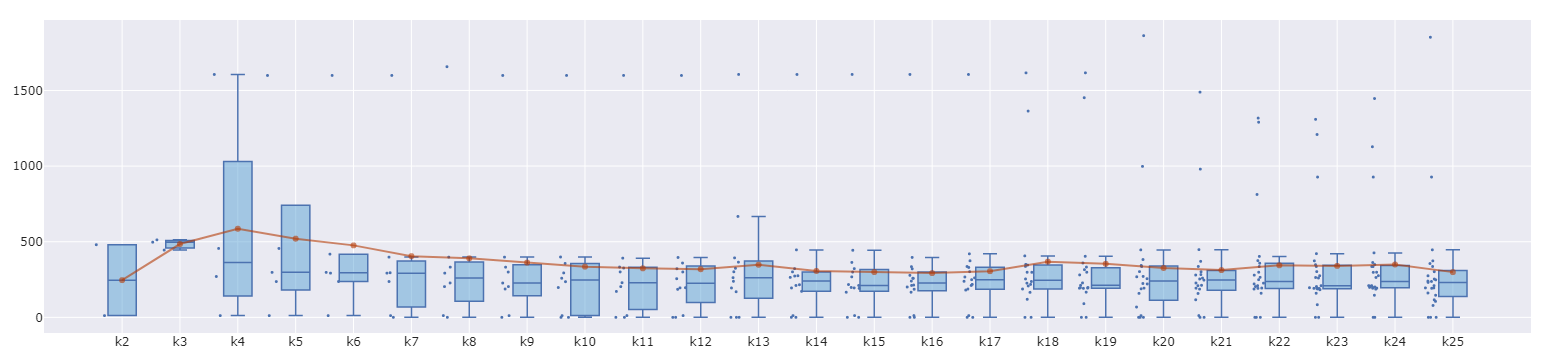

In [299]:
plot_elbow(DTAI_kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

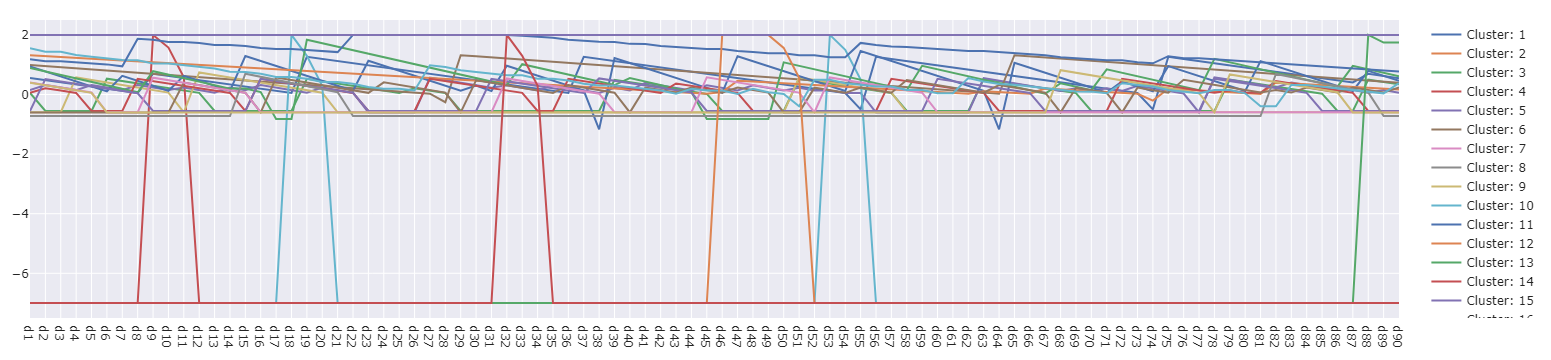

In [359]:
plot_centers(DTAI_kMedoids_centres, alg='KUMAP', k = 'k25')

---
# Saving Results

## Euclidean

In [350]:
solution_fileName = f'{solution_name}-Euc_Centers.csv'
solution_fileName

'LSTM_AE-efficient_sweep_2_v49-Euc_Centers.csv'

In [351]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
Euclidean_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)

## DTW

In [352]:
solution_fileName = f'{solution_name}-DTW_Centers.csv'
solution_fileName

'LSTM_AE-efficient_sweep_2_v49-DTW_Centers.csv'

In [353]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
DTW_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)

## kMedoid(DTW)

In [354]:
solution_fileName = f'{solution_name}-kMedoid_DTW_Centers.csv'
solution_fileName

'LSTM_AE-efficient_sweep_2_v49-kMedoid_DTW_Centers.csv'

In [355]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
DTAI_kMedoids_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)